In [4]:
import os
import shutil
import cv2
import pandas as pd
import tensorflow as tf
from keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import tensorflow 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Recall,Precision
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras import models, layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
root_path = Path("/content/Fish_Dataset/Fish_Dataset")
sub_paths = root_path.glob(r'**/*.png')
#converting to list, will deal with generator later
sub_paths = list(sub_paths)

#creating temporary list to handle generator
data = []
for i in range(len(sub_paths)):
    #get the 2nd from last directory name
    label = os.path.split(os.path.split(sub_paths[i])[0])[1]
    data.append([str(sub_paths[i]), label])
    
#Appending data to dataframe
df = pd.DataFrame(data, columns=['path', 'label'])
#Removing ground truths 
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)

In [6]:
#Splitting into training, validation, and testing data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2, shuffle=True)
train_df.count()
test_df.count()

path     7200
label    7200
dtype: int64

path     1800
label    1800
dtype: int64

In [7]:
#Importing images using image data preprocessing provided from keras
train_generator = ImageDataGenerator(validation_split=0.2)
test_generator = ImageDataGenerator()

train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)

val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = "path",
    y_col = "label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [8]:
# Model Initialization

base_model = VGG19(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(9,activation='softmax'))

# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

4

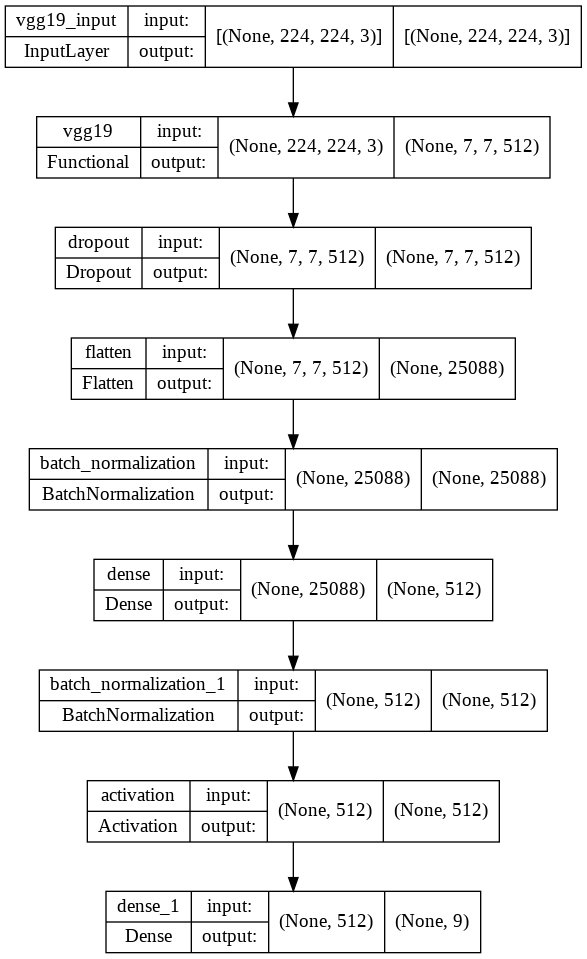

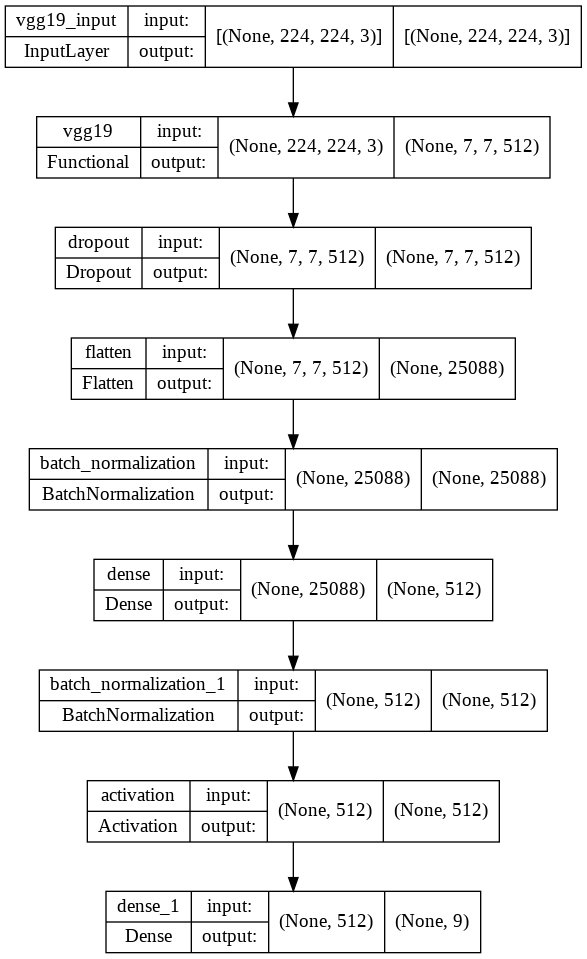

In [10]:
4

from keras.utils.vis_utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy',Precision(),Recall()],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [13]:
model_history=model.fit(train_imgs,
                        validation_data=val_imgs,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9222 - precision: 0.9454 - recall: 0.9047
Epoch 1: val_accuracy improved from -inf to 0.99167, saving model to ./best_weights.hdf5
180/180 [==============================] - 96s 495ms/step - loss: 0.2516 - accuracy: 0.9222 - precision: 0.9454 - recall: 0.9047 - val_loss: 0.0229 - val_accuracy: 0.9917 - val_precision: 0.9924 - val_recall: 0.9917
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9957 - precision: 0.9967 - recall: 0.9951
Epoch 2: val_accuracy improved from 0.99167 to 0.99792, saving model to ./best_weights.hdf5
180/180 [==============================] - 82s 457ms/step - loss: 0.0197 - accuracy: 0.9957 - precision: 0.9967 - recall: 0.9951 - val_loss: 0.0114 - val_accuracy: 0.9979 - val_precision: 0.9979 - val_recall: 0.9965
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9988 - precision: 0.9990 - rec

In [14]:
import keras
model.save('./best_weights.hdf5')
#model = keras.models.load_model('./best_weights.hdf5')

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

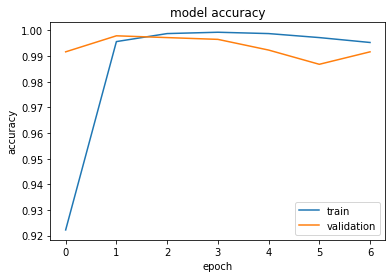

Text(0.5, 1.0, 'train set loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

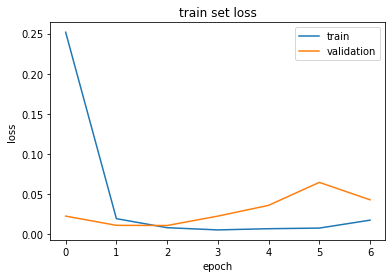

Text(0.5, 1.0, ' precision')

Text(0, 0.5, 'precision')

Text(0.5, 0, 'epoch')

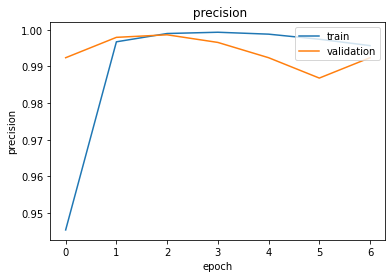

Text(0.5, 1.0, ' recall')

Text(0, 0.5, 'recall')

Text(0.5, 0, 'epoch')

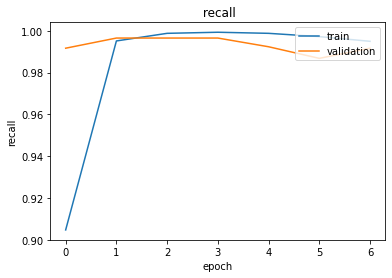

In [15]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(model_history.history['precision'])
plt.plot(model_history.history['val_precision'])
plt.title(' precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plt.plot(model_history.history['recall'])
plt.plot(model_history.history['val_recall'])
plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [16]:
loss, accuracy , precision,recall=model.evaluate(test_imgs)
print('Test Accuracy: %.3f' % accuracy)
print('Test Precision: %.3f' % precision)
print('Test Recall: %.3f' % recall)
print('Test loss: %.3f' % loss)

57/57 [==============================] - 24s 418ms/step - loss: 0.0444 - accuracy: 0.9867 - precision: 0.9872 - recall: 0.9867
Test Accuracy: 0.987
Test Precision: 0.987
Test Recall: 0.987
Test loss: 0.044


In [ ]:
y_pred = model.predict(test_imgs)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_imgs.labels,y_pred))